# Sentiment analysis on forum articles using word2vec and Keras

참고: http://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

원문과 달리 감정 분석이 아닌 정치글 성향을 분석하는 분류기를 만든다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

In [2]:
pd.options.mode.chained_assignment = None
from copy import deepcopy
from string import punctuation
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below

from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


데이타는 커뮤니티 게시글의 형태소 분석 결과 중 명사를 정리한 결과로 한다.  
커뮤니티 게시글인 관계로 비문이 많이 섞여 있다.

참고: http://docs.likejazz.com/cnn-text-classification-tf/

In [3]:
data = pd.read_csv('data/news-title-class.csv')

data.head(5)

,SentimentText,Sentiment
0,0 1 공통점,0
1,0 국어 구사 아이돌,0
2,04 도깨비 은탁 엔딩 사랑 물리학,0
3,1 1만 키로 정도,0
4,1 1박2일 2 정준영 등장 눈물 김종민,0


In [4]:
import nltk
# data['tokens'] = nltk.word_tokenize(data['SentimentText'])
data['tokens'] = ''
i = 0
for text in data['SentimentText']:
    data['tokens'][i] = nltk.word_tokenize(text)
    i += 1

data.head(5)

,SentimentText,Sentiment,tokens
0,0 1 공통점,0,"[0, 1, 공통점]"
1,0 국어 구사 아이돌,0,"[0, 국어, 구사, 아이돌]"
2,04 도깨비 은탁 엔딩 사랑 물리학,0,"[04, 도깨비, 은탁, 엔딩, 사랑, 물리학]"
3,1 1만 키로 정도,0,"[1, 1만, 키로, 정도]"
4,1 1박2일 2 정준영 등장 눈물 김종민,0,"[1, 1박2일, 2, 정준영, 등장, 눈물, 김종민]"


In [5]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.tokens),
                                                    np.array(data.Sentiment), test_size=0.2)
x_train.shape, y_test.shape

((5285,), (1322,))

In [6]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i, v in enumerate(tweets):
        label = '%s_%s' % (label_type, i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

In [7]:
x_train[0]

LabeledSentence(words=['콧구멍', '하악하악'], tags=['TRAIN_0'])

In [8]:
x_train[:10]

[LabeledSentence(words=['콧구멍', '하악하악'], tags=['TRAIN_0']),
 LabeledSentence(words=['윤종신', '실제', '느낌'], tags=['TRAIN_1']),
 LabeledSentence(words=['게시판'], tags=['TRAIN_2']),
 LabeledSentence(words=['후방'], tags=['TRAIN_3']),
 LabeledSentence(words=['주갤', '제보'], tags=['TRAIN_4']),
 LabeledSentence(words=['도깨비', '가장', '장면'], tags=['TRAIN_5']),
 LabeledSentence(words=['이정현', '새누리당', '대표', '장류', '셋트', '구매', '전송', '완료'], tags=['TRAIN_6']),
 LabeledSentence(words=['박근혜', '부역자', '황영철'], tags=['TRAIN_7']),
 LabeledSentence(words=['프로토', '하루', '따자'], tags=['TRAIN_8']),
 LabeledSentence(words=['메이커', '별', '품번', '특징', '정리', '1'], tags=['TRAIN_9'])]

In [9]:
[x.words for x in x_train][:10]

[['콧구멍', '하악하악'],
 ['윤종신', '실제', '느낌'],
 ['게시판'],
 ['후방'],
 ['주갤', '제보'],
 ['도깨비', '가장', '장면'],
 ['이정현', '새누리당', '대표', '장류', '셋트', '구매', '전송', '완료'],
 ['박근혜', '부역자', '황영철'],
 ['프로토', '하루', '따자'],
 ['메이커', '별', '품번', '특징', '정리', '1']]

In [10]:
# `size` is the dimensionality of the feature vectors.
# `window` is the maximum distance between the current and predicted word within a sentence.
# `min_count` = ignore all words with total frequency lower than this.
tweet_w2v = Word2Vec(size=200, window=3, min_count=2)
tweet_w2v.build_vocab([x.words for x in x_train])
tweet_w2v.train([x.words for x in x_train], total_examples=tweet_w2v.corpus_count, epochs=5)

75624

In [11]:
tweet_w2v.corpus_count, len(tweet_w2v.wv.vocab)

(5285, 2612)

In [12]:
tweet_w2v.most_similar('박근혜')

[('탄핵', 0.45850053429603577),
 ('때', 0.3880687355995178),
 ('일본', 0.38755983114242554),
 ('사람', 0.36928194761276245),
 ('의원', 0.3663651645183563),
 ('대통령', 0.3569279909133911),
 ('게임', 0.35518980026245117),
 ('전', 0.35461631417274475),
 ('고영태', 0.34320682287216187),
 ('우병우', 0.33934956789016724)]

In [13]:
tweet_w2v.most_similar('문재인')

[('의원', 0.33990582823753357),
 ('시장', 0.3274620771408081),
 ('우병우', 0.3198774755001068),
 ('탄핵', 0.31063830852508545),
 ('이유', 0.30737459659576416),
 ('인가', 0.2894013524055481),
 ('가결', 0.28872376680374146),
 ('게임', 0.28291991353034973),
 ('황교안', 0.28228309750556946),
 ('박근혜', 0.28173351287841797)]

In [14]:
tweet_w2v.most_similar('김제동')

[('소리야', 0.24287334084510803),
 ('온라인', 0.2331192046403885),
 ('조심', 0.2304215282201767),
 ('결론', 0.2289251685142517),
 ('자존심', 0.22776442766189575),
 ('당시', 0.21566548943519592),
 ('급', 0.21559274196624756),
 ('단일화', 0.21372069418430328),
 ('새누리당', 0.2122083604335785),
 ('41', 0.21167846024036407)]

In [15]:
w = tweet_w2v.wv.vocab.keys()
# word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab.keys()[:10]]
list(w)[:10]

['실제', '느낌', '게시판', '후방', '주갤', '제보', '도깨비', '가장', '장면', '이정현']

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.006469
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.759106
[t-SNE] Error after 400 iterations: 1.759106


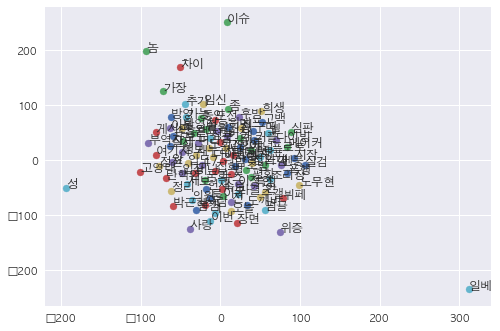

In [16]:
# getting a list of word vectors. limit to 100. each is of 100 dimensions
word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab.keys()]
word_vectors = list(word_vectors)[:100]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:100]

import matplotlib
matplotlib.rc('font', family='AppleGothic')

i = 0
for i in range(tsne_df['words'].size):
    plt.scatter(tsne_df['x'][i], tsne_df['y'][i])
    plt.annotate(tsne_df['words'][i],
                 xy=(tsne_df['x'][i],tsne_df['y'][i]))

plt.show()

t-SNE의 값은 PCA와 달리 지나치게 랜덤하게 변해서 올바른 현상인지 확인이 필요하다.

In [17]:
print ('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=2)
matrix = vectorizer.fit_transform([x.words for x in x_train])
matrix.shape

building tf-idf matrix ...


(5285, 2587)

In [18]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 2587


In [19]:
tfidf['문재인']

5.1539764873676361

In [20]:
tfidf['박근혜']

4.5892104734558981

tfidf를 워드 벡터에 반영한다.

In [21]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [22]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in map(lambda x: x.words, x_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in map(lambda x: x.words, x_test)])
test_vecs_w2v = scale(test_vecs_w2v)

train_vecs_w2v.shape

(5285, 200)

In [23]:
test_v = {}
test_tfidf = {}

test_v['A'] = np.array([0.1, 0.4])
test_v['B'] = np.array([0.2, 0.3])
test_v['C'] = np.array([0.3, 0.9])

test_tfidf['A'] = 4
test_tfidf['B'] = 10
test_tfidf['C'] = 7

def testBuildWordVector(tokens, size):
    vec = np.zeros(size).reshape(1,size)
    count = 0.
    for word in tokens:
        # token에 해당하는 벡터에 tfidf 가중치 부여하여 합산
        vec += test_v[word].reshape(1,size) * test_tfidf[word]
        count += 1.

    # token 수 만큼 나누어 1 token 기준 벡터 값 추출
    vec /= count
    
    return vec
    # vec

# 각 벡터를 하나의 numpy array로 join
test_v = np.concatenate([testBuildWordVector(z, 2) for z in [['A', 'B', 'C'], ['C']]])
test_v

array([[ 1.5       ,  3.63333333],
       [ 2.1       ,  6.3       ]])

# Just regular densely-connected NN layer

In [24]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(train_vecs_w2v, y_train, epochs=120, batch_size=32, verbose=0,
          validation_split=0.2,
          callbacks=[TQDMNotebookCallback(show_inner=False)])

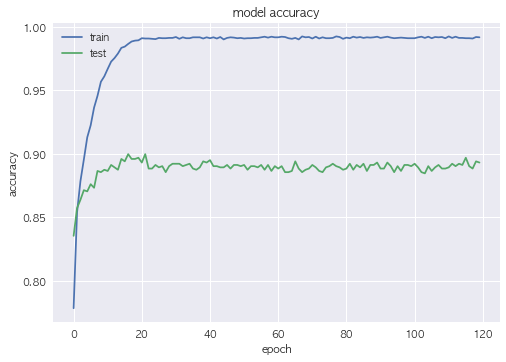

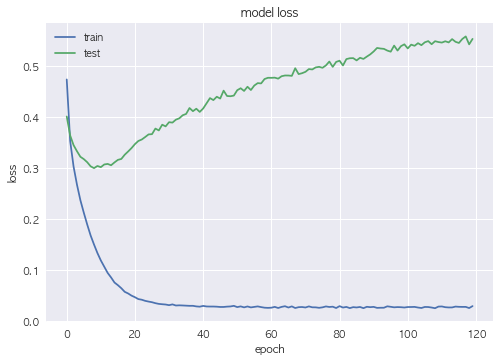

In [26]:
plot_history(history)

In [27]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
score # score[1] is accuracy

[0.48672030119960857, 0.90620272332709428]

In [28]:
train_vecs_w2v.shape

(5285, 200)

# embedding

- pad_sequences for embedding
- word2vec
    - word2vec embedding
    - reshape model for CNN

# pad_sequences for embedding
2차원의 값이 `(5250,)`등으로 명확히 정의되어 있지 않을때는 `pad_sequence`로 `maxlen` 만큼의 고정 길이를 할당해야 임베딩 적용이 가능하다.

우리는 이미 고정 길이로 할당된 상태이기 때문에 의미가 없다.

In [29]:
train_vecs_w2v.shape

(5285, 200)

In [30]:
from keras.preprocessing import sequence
print("Pad sequences (samples x time)")
train_vecs_w2v = sequence.pad_sequences(train_vecs_w2v, maxlen=200)

Pad sequences (samples x time)


In [31]:
train_vecs_w2v.shape

(5285, 200)

수치 벡터로 표현한 문장의 임베딩은 아래와 같이 진행한다. (one-hot encoding 아님)

* `input_dim`: 중복을 제외한 전체 단어 수
* `output_dim`: 임베딩 할 차원의 수
* `input_length`: 가장 긴 문장의 단어 수

```
model = Sequential()
model.add(Embedding(input_dim=25000, output_dim=5, 
                    input_length=40))
model.add(SpatialDropout1D(0.2))
```

Output Shape는 `(None, 40, 5)`이 된다.

추후 CNN등에서 filter size를 5로 설정하면 임베딩 차원을 그대로 유지하며 진행한다.

# word2vec
## word2vec embedding

```
vocab_sz = 5285
EMBED_SIZE = 200

embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
embedding_weights[0,:] = [1,2,3 ... 200]

model.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen,
          weights=[embedding_weights]))
```
이 경우 `fit()` 실행시 문장의 벡터를 입력하고 word2vec은 weights로 삽입한다. weights는 각 단어별 word2vec 값이다.

여기서는 임베딩 차원의 수가 word2vec 임베딩과 동일하다. 나중에 CNN의 filters(필터의 갯수)도 이 값으로 처리된다. 즉, 200을 유지하려면 filters=200으로 진행해야 한다.

우리는 이미 상기에서 각 단어별 word2vec 값에 tfidf 가중치를 부여하고 문장을 토큰 단위 평균을 낸 상태이기 때문에 이 과정이 의미가 없다.

## reshape model for CNN

In [32]:
train_vecs_w2v.shape

(5285, 200)

In [33]:
# CNN filters와 값을 맞추기 위해 5로 설정해봤으나 `cannot reshape array` 오류 발생. 1로 진행한다.
train_vecs_w2v = train_vecs_w2v.reshape(train_vecs_w2v.shape[0], train_vecs_w2v.shape[1], 1)
train_vecs_w2v.shape, y_train.shape

((5285, 200, 1), (5285,))

In [34]:
test_vecs_w2v = test_vecs_w2v.reshape(test_vecs_w2v.shape[0], test_vecs_w2v.shape[1], 1)
test_vecs_w2v.shape

(1322, 200, 1)

# 1D convolution layer

In [35]:
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Flatten, Dropout, Embedding, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout1D
from keras.models import Sequential

model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters=5, kernel_size=3, activation='relu', input_shape=[200,1]))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(3))

# GlobalMaxPooling1D는 필터 수 만큼 남긴다.
# model.add(GlobalMaxPooling1D())
# Flatten은 2차원x3차원(필터 수)를 합한 만큼 2차원에 표현(추가됨)한다.
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(10))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 5)            20        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 5)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 63, 5)             105       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 5)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 5)             130       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25)                0         
__________

In [36]:
history = model.fit(train_vecs_w2v, y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[TQDMNotebookCallback(show_inner=False)])

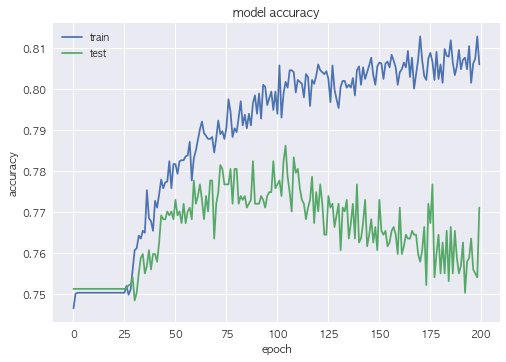

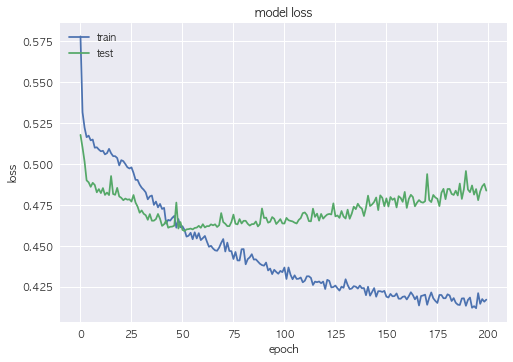

In [37]:
plot_history(history)

In [38]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
score # score[1] is accuracy

[0.64774580036096963, 0.69591527942810405]

In [39]:
model.metrics_names

['loss', 'acc']